# Feature Engineering (adding sentiment scores, normalizing data & adding new features)

## After testing lots of sentiment analysis models, we are going to be using "ROBERTA MODEL" as it prevails over all the others (As of now in 2024). 

In [1]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)


/Users/staschernyshov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/staschernyshov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/staschernyshov/opt/anaconda3/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


# "TESTING OUR ROBERTA MODEL"

## Importing our Cleaned NYT Data

In [2]:
# Define the file paths
file_path = 'Final Cleaned Data/Final_NYT_articles.csv'

# Read the CSV files
NYT_articles = pd.read_csv(file_path)

NYT_articles.insert(0, 'article_count', range(1, len(NYT_articles) + 1))
NYT_articles.tail()





,article_count,pub_date,headline,abstract,lead_paragraph,byline,section_name,web_url,source,multimedia_url
144,145,2024-06-01T11:00:06+0000,Oil and Gas Companies Are Trying to Rig the Ma...,Fossil fuel interests are spreading misinforma...,Many of us focused on the problem of climate c...,By Andrew Dessler,Opinion,https://www.nytimes.com/2024/06/01/opinion/cle...,The New York Times,https://www.nytimes.com/images/2024/06/03/opin...
145,146,2024-07-07T19:55:06+0000,"Officials Urge Coastal Texans to Evacuate, but...",Despite warnings that Beryl could be a “deadly...,As Beryl chugged toward the Texas Gulf Coast o...,"By Edgar Sandoval, Maria Jimenez Moya and Jack...",U.S.,https://www.nytimes.com/2024/07/07/us/texas-ev...,The New York Times,https://www.nytimes.com/images/2024/07/07/mult...
146,147,2024-07-07T09:00:16+0000,New Plan to Target Russia’s Oil Revenue Brings...,Treasury officials want to impose penalties on...,Officials in President Biden’s Treasury Depart...,By Jim Tankersley and Alan Rappeport,U.S.,https://www.nytimes.com/2024/07/07/us/politics...,The New York Times,https://www.nytimes.com/images/2024/06/25/mult...
147,148,2024-07-06T10:00:05+0000,"Facing New ‘Greenwashing’ Law, an Oil Industry...",Oil sands companies pushing a carbon capture p...,When Parliament passed a law last month bannin...,By Ian Austen,World,https://www.nytimes.com/2024/07/06/world/canad...,The New York Times,https://www.nytimes.com/images/2024/07/06/mult...
148,149,2024-07-02T01:23:39+0000,Judge Orders Biden Administration to Resume Pe...,President Biden had paused new natural gas exp...,A federal judge on Monday ordered the Biden ad...,By Coral Davenport,Climate,https://www.nytimes.com/2024/07/01/climate/fed...,The New York Times,https://www.nytimes.com/images/2024/07/01/mult...


## Creating the function to add sentiment scores

In [3]:
example = NYT_articles["headline"][4]
print(f"Example: {example}")
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative_sentiment_score' : scores[0],
        'neutral_sentiment_score' : scores[1],
        'positive_sentiment_score' : scores[2],
        'compound_sentiment_score' : np.dot(scores, [-1, 0, 1]) 
    }
    return scores_dict

polarity_scores_roberta(example)

Example: White House Said to Delay Decision on Enormous Natural Gas Export Terminal


{'negative_sentiment_score': 0.19727981,
 'neutral_sentiment_score': 0.78225654,
 'positive_sentiment_score': 0.020463653,
 'compound_sentiment_score': -0.1768161579966545}

# In NYT data we have lots of text columns, we need to go over some examples to see which column should we use for our sentiment scores.

In [4]:
pd.set_option('display.max_colwidth', None) 
NYT_articles.iloc[4][['article_count', 'headline', 'abstract', 'lead_paragraph']]

article_count                                                                                                                                                                                                                                                                                                                                      5
headline                                                                                                                                                                                                                                                                  White House Said to Delay Decision on Enormous Natural Gas Export Terminal
abstract                                                                                                                                                                                              Before deciding whether to approve it, the Energy Department will analyze the climate impacts of CP2, one of 17 proposed

# As we can see the columns have different text sizes as expected lets run the sentiment scores on each column and objectively choose which column is better to keep track of sentiment scores.

In [5]:
example = NYT_articles["headline"][4]
example2 = NYT_articles["abstract"][4]
example3 = NYT_articles["lead_paragraph"][4]

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative_sentiment_score' : scores[0],
        'neutral_sentiment_score' : scores[1],
        'positive_sentiment_score' : scores[2],
        'compound_sentiment_score' : np.dot(scores, [-1, 0, 1]) 
    }
    return scores_dict
print(f"Example: {example}")
print(polarity_scores_roberta(example))

print(f"Example: {example2}")
print(polarity_scores_roberta(example2))

print(f"Example: {example3}")
print(polarity_scores_roberta(example3))

Example: White House Said to Delay Decision on Enormous Natural Gas Export Terminal
{'negative_sentiment_score': 0.19727981, 'neutral_sentiment_score': 0.78225654, 'positive_sentiment_score': 0.020463653, 'compound_sentiment_score': -0.1768161579966545}
Example: Before deciding whether to approve it, the Energy Department will analyze the climate impacts of CP2, one of 17 proposed LNG export terminals.
{'negative_sentiment_score': 0.09672564, 'neutral_sentiment_score': 0.87878036, 'positive_sentiment_score': 0.02449399, 'compound_sentiment_score': -0.07223165221512318}
Example: The Biden administration is pausing a decision on whether to approve what would be the largest natural gas export terminal in the United States, a delay that could stretch past the November election and spell trouble for that project and 16 other proposed terminals, according to three people with knowledge of the matter.
{'negative_sentiment_score': 0.6261945, 'neutral_sentiment_score': 0.3558002, 'positive_sent

## The sentiment score of lead paragraph appears to be much more negative.

## Let's do a different article 

In [6]:
example = NYT_articles["headline"][6]
example2 = NYT_articles["abstract"][6]
example3 = NYT_articles["lead_paragraph"][6]

print(f"Example: {example}")
print(polarity_scores_roberta(example))

print(f"Example: {example2}")
print(polarity_scores_roberta(example2))

print(f"Example: {example3}")
print(polarity_scores_roberta(example3))

Example: To Slash Carbon Emissions, Colleges Are Digging Really Deep
{'negative_sentiment_score': 0.13952605, 'neutral_sentiment_score': 0.7351717, 'positive_sentiment_score': 0.12530227, 'compound_sentiment_score': -0.01422378420829773}
Example: A growing number of colleges and universities are using deep underground pipes to heat and cool their buildings without burning fossil fuels.
{'negative_sentiment_score': 0.03893204, 'neutral_sentiment_score': 0.732312, 'positive_sentiment_score': 0.22875598, 'compound_sentiment_score': 0.1898239403963089}
Example: When administrators at Princeton University decided to cut the carbon emissions that came from heating and cooling their campus, they opted for a method that is gaining popularity among colleges and universities.
{'negative_sentiment_score': 0.010158518, 'neutral_sentiment_score': 0.47147632, 'positive_sentiment_score': 0.51836514, 'compound_sentiment_score': 0.5082066264003515}


In [7]:
example = NYT_articles["headline"][8]
example2 = NYT_articles["abstract"][8]
example3 = NYT_articles["lead_paragraph"][8]


print(f"Example: {example}")
print(polarity_scores_roberta(example))

print(f"Example: {example2}")
print(polarity_scores_roberta(example2))

print(f"Example: {example3}")
print(polarity_scores_roberta(example3))

Example: Ukraine Targets Russian Oil Plants, Aiming to Disrupt Military Operations
{'negative_sentiment_score': 0.75273335, 'neutral_sentiment_score': 0.24250716, 'positive_sentiment_score': 0.0047594877, 'compound_sentiment_score': -0.7479738621041179}
Example: Kyiv hit an oil depot on Friday, the latest in recent attacks on such facilities as it seeks to inflict damage away from the largely deadlocked front line.
{'negative_sentiment_score': 0.8099761, 'neutral_sentiment_score': 0.18588692, 'positive_sentiment_score': 0.0041369763, 'compound_sentiment_score': -0.8058391246013343}
Example: Ukraine hit an oil depot in Russia in a drone attack on Friday, officials on both sides said, the latest in a series of recent assaults targeting Russian oil facilities as Kyiv increasingly seeks to strike critical infrastructure behind Russian lines.
{'negative_sentiment_score': 0.76570624, 'neutral_sentiment_score': 0.22955814, 'positive_sentiment_score': 0.0047356477, 'compound_sentiment_score': 

# In this example the sentiment score is more or less the same. 

In [8]:
example = NYT_articles["headline"][13]
example2 = NYT_articles["abstract"][13]
example3 = NYT_articles["lead_paragraph"][13]


print(f"Example: {example}")
print(polarity_scores_roberta(example))

print(f"Example: {example2}")
print(polarity_scores_roberta(example2))

print(f"Example: {example3}")
print(polarity_scores_roberta(example3))

Example: Biden Administration to Fine Oil and Gas Companies for Excess Methane
{'negative_sentiment_score': 0.18190868, 'neutral_sentiment_score': 0.79285306, 'positive_sentiment_score': 0.025238229, 'compound_sentiment_score': -0.15667045302689075}
Example: A plan to impose a fee of $900 to $1,500 on every excess ton of methane emissions would be the first federal price on greenhouse gas pollution.
{'negative_sentiment_score': 0.31265682, 'neutral_sentiment_score': 0.6591446, 'positive_sentiment_score': 0.028198589, 'compound_sentiment_score': -0.2844582311809063}
Example: The Biden administration announced new moves on Friday to curb the release from oil and gas facilities of methane, a potent greenhouse gas that is responsible for more than a quarter of the warming the planet is currently experiencing.
{'negative_sentiment_score': 0.25499666, 'neutral_sentiment_score': 0.6819029, 'positive_sentiment_score': 0.06310048, 'compound_sentiment_score': -0.19189617782831192}


## Both 3 compund scores are same as well. 

In [9]:
example = NYT_articles["headline"][20]
example2 = NYT_articles["abstract"][20]
example3 = NYT_articles["lead_paragraph"][20]


print(f"Example: {example}")
print(polarity_scores_roberta(example))

print(f"Example: {example2}")
print(polarity_scores_roberta(example2))

print(f"Example: {example3}")
print(polarity_scores_roberta(example3))

Example: Missing Profits May Be a Problem for the Green Transition
{'negative_sentiment_score': 0.65399086, 'neutral_sentiment_score': 0.32308462, 'positive_sentiment_score': 0.022924501, 'compound_sentiment_score': -0.6310663633048534}
Example: The inability to generate acceptable returns is impeding the switch to renewable energy.
{'negative_sentiment_score': 0.724043, 'neutral_sentiment_score': 0.2592742, 'positive_sentiment_score': 0.01668281, 'compound_sentiment_score': -0.7073602024465799}
Example: In October, the International Energy Agency issued a brief flare of optimism when it suggested that global carbon emissions from fossil fuels may already have peaked.
{'negative_sentiment_score': 0.025541592, 'neutral_sentiment_score': 0.3825491, 'positive_sentiment_score': 0.5919093, 'compound_sentiment_score': 0.5663676969707012}


# "Missing Profits May Be a Problem for the Green Transition" this is negative compund for the green energy, however this is positive for the crude oil....

## There are two things we can do: 

### 1)Filter out the Articles or future tweets with the word containing green. 
### or 
### 2)If we have a negative compound for the green energy, we can do the opposise of -0.63 to +0.63 for that article. 

## Extracting the Article Related to Green Energy and Analyzing them to create a code that would classify them as "Green Energy"

In [10]:

keywords = r'green|renewable'

# Filter rows where these words appear in the 'headline', 'abstract', or 'lead_paragraph'
filtered_rows = NYT_articles[NYT_articles[['headline', 'abstract', 'lead_paragraph']].apply(
    lambda x: x.str.contains(keywords, case=False, na=False).any(), axis=1)]

# Print the filtered rows with selected columns
filtered_rows[['article_count', 'headline', 'abstract', 'lead_paragraph']]


,article_count,headline,abstract,lead_paragraph
13,14,Biden Administration to Fine Oil and Gas Companies for Excess Methane,"A plan to impose a fee of $900 to $1,500 on every excess ton of methane emissions would be the first federal price on greenhouse gas pollution.","The Biden administration announced new moves on Friday to curb the release from oil and gas facilities of methane, a potent greenhouse gas that is responsible for more than a quarter of the warming the planet is currently experiencing."
20,21,Missing Profits May Be a Problem for the Green Transition,The inability to generate acceptable returns is impeding the switch to renewable energy.,"In October, the International Energy Agency issued a brief flare of optimism when it suggested that global carbon emissions from fossil fuels may already have peaked."
21,22,U.S. Carbon Emissions Fell in 2023 as Coal Use Tumbled to New Lows,"The drop was big, but emissions will need to fall three times as fast for the rest of the decade if the country wants to meet its climate goals.","America’s greenhouse gas emissions fell 1.9 percent in 2023, in large part because the burning of coal to produce electricity plummeted to its lowest level in half a century, according to estimates published on Wednesday by the Rhodium Group, a nonpartisan research firm."
43,44,"BP to Increase Oil Output, New Chief Says","Murray Auchincloss signaled that he would take a more profit-oriented approach than his predecessor, who started a big push into renewables.","BP’s new chief executive, Murray Auchincloss, promised a flexible approach to the shift away from fossil fuels as the oil giant reported a $3 billion profit in its latest quarter on Tuesday."
52,53,"‘Garbage Lasagna’: Dumps Are a Big Driver of Warming, Study Says","Decades of buried trash is releasing methane, a powerful greenhouse gas, at higher rates than previously estimated, the researchers said.","They’re vast expanses that can be as big as towns: open landfills where household waste ends up, whether it’s vegetable scraps or old appliances."
66,67,"Oil Fields Release Far More Methane Than Thought, Study Finds","In parts of New Mexico, more than 9 percent of all natural gas produced goes into the atmosphere, where it acts as a powerful greenhouse gas.","Oil and gas producers in major oil fields across the United States may be emitting three times as much planet-warming methane gas as official estimates, according to new research published Wednesday, the latest study to suggest that emissions from the fossil fuel sector may be grossly undercounted."
75,76,Corn to Power Airplanes? Biden Administration Sets a High Bar.,"Producers of biofuels like ethanol, which could help create a new generation of jet fuel, would have to overhaul their practices to receive tax credits.","In a move aimed at lowering the greenhouse gas emissions of air travel, the Biden administration on Tuesday issued new guidelines for how fuel producers — and in particular, makers of ethanol from corn — could qualify for tax credits under a plan to increase the supply of so-called sustainable aviation fuel."
107,108,How China Rose to Lead the World in Cars and Solar Panels,"Heavy subsidies for industry, together with weak sales in China, have set the stage for an export boom, raising fears of factory job losses elsewhere.","For decades, China has moved methodically to dominate ever more industries, from toys and clothing in the 1980s to semiconductors and renewable energy today. China now produces a third of the world’s manufactured goods — more than the United States, Germany, Japan, South Korea and Britain combined. Its trade surplus in these goods is equal to a tenth of the entire Chinese economy."
121,122,"Oil Companies Expand Offshore Drilling, Pointing to Energy Needs",Shell and others say they plan to drill for oil and gas in the Gulf of Mexico in part because doing so releases fewer greenhouse gases than drilling on land.,"About 80 miles southeast of Louisiana’

In [11]:
example = NYT_articles["headline"][20]
example2 = NYT_articles["abstract"][20]
example3 = NYT_articles["lead_paragraph"][20]


print(f"Example: {example}")
print(polarity_scores_roberta(example))

print(f"Example: {example2}")
print(polarity_scores_roberta(example2))

print(f"Example: {example3}")
print(polarity_scores_roberta(example3))

Example: Missing Profits May Be a Problem for the Green Transition
{'negative_sentiment_score': 0.65399086, 'neutral_sentiment_score': 0.32308462, 'positive_sentiment_score': 0.022924501, 'compound_sentiment_score': -0.6310663633048534}
Example: The inability to generate acceptable returns is impeding the switch to renewable energy.
{'negative_sentiment_score': 0.724043, 'neutral_sentiment_score': 0.2592742, 'positive_sentiment_score': 0.01668281, 'compound_sentiment_score': -0.7073602024465799}
Example: In October, the International Energy Agency issued a brief flare of optimism when it suggested that global carbon emissions from fossil fuels may already have peaked.
{'negative_sentiment_score': 0.025541592, 'neutral_sentiment_score': 0.3825491, 'positive_sentiment_score': 0.5919093, 'compound_sentiment_score': 0.5663676969707012}


We are essentially dealing with contextual sentiment, where the sentiment's impact on crude oil depends on the article's subject matter. If an article positively discusses green energy, it may imply negative sentiment for crude oil, even if the overall sentiment is positive. Here’s how you can handle this:

1. **Topic Classification:**
   - First, classify the article into categories like "Crude Oil," "Green Energy," or "Other." This way, you can identify whether the article primarily discusses topics related to oil or green energy.
   - Use NLP models like BERT or LDA (Latent Dirichlet Allocation) for topic modeling or classification.

2. **Custom Sentiment Mapping:**
   - After topic classification, you can define custom sentiment rules:
     - For articles classified under "Green Energy," if the sentiment is positive, map it as negative for crude oil.
     - For articles under "Crude Oil," positive sentiment should remain positive for crude oil.

3. **Sentiment Recalibration:**
   - Once you have the article's topic, adjust the sentiment scores based on the category. For instance:
     - Positive sentiment for "Green Energy" → Negative sentiment for crude oil.
     - Positive sentiment for "Crude Oil" → Positive sentiment for crude oil.



## Writing Code so that it smoothly adds to the whole dataset

In [12]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm
import re

# load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

# Function to calculate sentiment scores
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative_sentiment_score': scores[0],
        'neutral_sentiment_score': scores[1],
        'positive_sentiment_score': scores[2],
        'compound_sentiment_score': np.dot(scores, [-1, 0, 1])
    }
    return scores_dict

# Function to classify article as 'Crude Oil', 'Green Energy', or 'Other'
def classify_article(row):
    text = row['headline'] + " " + row['abstract']
    text = text.lower()  # Convert text to lowercase for consistent matching

    crude_oil_patterns = [
        r'\boil\b',  
        r'crude oil', 
        r'oil price(?:s)?',  
        r'oil market(?:s)?', 
        r'oil production', 
        r'oil demand(?:s)?', 
        r'oil supply', 
        r'oil reserves?',  
        r'oil futures?', 
        r'oil barrel(?:s)?', 
        r'oil drilling', 
        r'oil rigs?', 
        r'oil refinery', 
        r'oilfield', 
        r'oil well(?:s)?',  
        r'exxonmobil', 
        r'bp', 
        r'chevron', 
        r'shell', 
        r'totalenergies', 
        r'u\.s\. shale',  
        r'oil sanctions?', 
        r'oil embargo(?:es)?', 
        r'petroleum', 
        r'petroleum price(?:s)?',
        r'\bpetrol\b',
        r'\bgas\b',  
        r'\bgasoline\b',  
        r'gasoline price(?:s)?',
        r'fossil fuel(?:s)?', 
        r'hydrocarbon(?:s)?', 
        r'shale oil', 
        r'tar sands?', 
        r'brent crude', 
        r'west texas intermediate',
        r'\bWTI\b',  
        r'\bcoal\b',
        r'\bfuel\b',
        r'\bOPEC\b',
    ]

    green_energy_patterns = [
        r'green',
        r'green energy', 
        r'renewable(?:s)?',  
        r'solar', 
        r'wind', 
        r'clean energy', 
        r'green transition', 
        r'carbon neutral', 
        r'clean tech(?:nologies)?',  
        r'\bclimate change\b',       
        r'\bgreenhouse\b',           
        r'\bclimate\b',
        r'\benvironment\b',
        r'\benvironmental\b',            
    ]

    # Check if any crude oil related pattern matches the text
    if any(re.search(pattern, text) for pattern in crude_oil_patterns):
        return 'Crude Oil'
    
    # Check if any green energy related pattern matches the text
    elif any(re.search(pattern, text) for pattern in green_energy_patterns):
        return 'Green Energy'
    
    else:
        return 'Other'

# Adjust sentiment based on the topic of the article and invert the sentiment for Green Energy
def adjust_sentiment_based_on_topic(sentiment_dict, topic):
    # If the article is about Green Energy, invert the compound sentiment score
    if topic == 'Green Energy':
        sentiment_dict['compound_sentiment_score'] = -sentiment_dict['compound_sentiment_score']
        sentiment_dict['negative_sentiment_score'] = -sentiment_dict['negative_sentiment_score']
        sentiment_dict['positive_sentiment_score'] = -sentiment_dict['positive_sentiment_score']
        
    
    return sentiment_dict

# DataFrame to store results
res = {}

for i, row in tqdm(NYT_articles.iterrows(), total=len(NYT_articles)):
    try:
        text = row['headline']
        myid = row['article_count']
        
        # Check for missing data
        if pd.isnull(row['headline']) or pd.isnull(row['abstract']):
            continue
        
        # Step 1: Get sentiment scores
        sentiment_scores = polarity_scores_roberta(text)
        
        # Step 2: Classify the article topic
        topic = classify_article(row)
        
        # Step 3: Adjust sentiment based on the topic
        sentiment_scores = adjust_sentiment_based_on_topic(sentiment_scores, topic)
        
        # Step 4: Store sentiment scores and classification
        sentiment_scores['classification'] = topic
        res[myid] = sentiment_scores

    except Exception as e:
        print(f'Error for article {myid}: {e}')

# Convert results into DataFrame
results_df = pd.DataFrame(res).T

# Add the classification column
results_df = results_df.reset_index().rename(columns={'index': 'article_count'})
results_df = results_df.merge(NYT_articles, how='left')
NYT_articles = results_df
# Display final DataFrame with classification
NYT_articles.head()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 149/149 [00:09<00:00, 14.97it/s]


,article_count,negative_sentiment_score,neutral_sentiment_score,positive_sentiment_score,compound_sentiment_score,classification,pub_date,headline,abstract,lead_paragraph,byline,section_name,web_url,source,multimedia_url
0,1,0.368058,0.601618,0.030324,-0.337734,Crude Oil,2024-01-30T13:40:11+0000,Saudi Aramco Abruptly Drops Plans to Expand Oil Production,"The pullback, at the behest of the Saudi government and made with little comment, probably reflects a more subdued outlook for demand of Saudi Arabia’s oil.","Saudi Aramco said Tuesday that it would call off plans to expand its oil output, a remarkable turnaround by one of the world’s leading petroleum producers.",By Stanley Reed,Business Day,https://www.nytimes.com/2024/01/30/business/saudi-aramco-oil-production.html,The New York Times,https://www.nytimes.com/images/2024/01/30/multimedia/30aramco-01-pgwm/30aramco-01-pgwm-articleLarge.jpg
1,2,0.166939,0.778636,0.054426,-0.112513,Crude Oil,2024-01-29T10:01:56+0000,Where Southerners Go to Fill the Tank and Feed the Family,Are they gas stations that serve food or restaurants that pump gas? A new photography book explores the lure of these restorative community rest stops.,New York City has its bodegas. The South has its gas stations.,By Kim Severson,Food,https://www.nytimes.com/2024/01/29/dining/southern-gas-station-restaurants.html,The New York Times,https://www.nytimes.com/images/2024/01/31/multimedia/31Gas-Station-Food4-vqpm/29Gas-Station-Food4-vqpm-articleLarge.jpg
2,3,-0.505036,0.465767,-0.029197,0.475839,Green Energy,2024-01-27T08:00:40+0000,Democrats Say Biden Hasn’t ‘Made the Case’ on Climate Despite Achievements,The president likes to talk about his climate agenda as an opportunity to create jobs. Polling shows that may be the wrong way to win over voters.,"President Biden has done more than any president to tackle climate change, but strategists are grappling with an uncomfortable fact: Voters don’t seem to know it.",By Lisa Friedman,Climate,https://www.nytimes.com/2024/01/27/climate/biden-climate-campaign.html,The New York Times,https://www.nytimes.com/images/2024/01/26/multimedia/00cli-bidenclimatepitch-01-hpfc/00cli-bidenclimatepitch-01-hpfc-articleLarge.jpg
3,4,0.418735,0.560968,0.020298,-0.398437,Other,2024-01-24T19:59:53+0000,Shipping Costs Soar in Wake of Red Sea Attacks,"Ships risking Houthi attacks must pay high insurance premiums, while vessels avoiding the region lose time going around Africa.","For about two months, a barrage of missile and drone attacks in the Red Sea by Houthi militants has posed a difficult choice to shipowners using the Suez Canal: risk an airborne strike and pay sharply higher insurance rates, or forgo the canal and take the longer route around Africa, snarling schedules and entailing higher fuel charges.",By Stanley Reed,Business Day,https://www.nytimes.com/2024/01/24/business/red-sea-attacks-shipping-costs.html,The New York Times,https://www.nytimes.com/images/2024/01/23/multimedia/00redsea-shipping-zgjk/00redsea-shipping-zgjk-articleLarge.jpg
4,5,0.19728,0.782257,0.020464,-0.176816,Crude Oil,2024-01-24T17:59:40+0000,White House Said to Delay Decision on Enormous Natural Gas Export Terminal,"Before deciding whether to approve it, the Energy Department will analyze the climate impacts of CP2, one of 17 proposed LNG export terminals.","The Biden administration is pausing a decision on whether to approve what would be the largest natural gas export terminal in the United States, a delay that could stretch past the November election and spell trouble for that project and 16 other proposed terminals, according to three people with knowledge of the matter.",By Coral Davenport,Climate,https://www.nytimes.com/2024/01/24/climate/biden-lng-export-terminal-cp2.html,The New York Times,https://www.nytimes.com/images/2024/01/24/multimedia/24cli-gasfight-02-lfzw/24cli-gasfight-02-lfzw-articleLarge.jpg


## As we can see below the article that talks about the Green Energy is negative now. As good for Green means bad for crude oil.

In [13]:
NYT_articles.iloc[20]

article_count                                                                                                                                                                                   21
negative_sentiment_score                                                                                                                                                                 -0.653991
neutral_sentiment_score                                                                                                                                                                   0.323085
positive_sentiment_score                                                                                                                                                                 -0.022925
compound_sentiment_score                                                                                                                                                                  0.631066
classification           

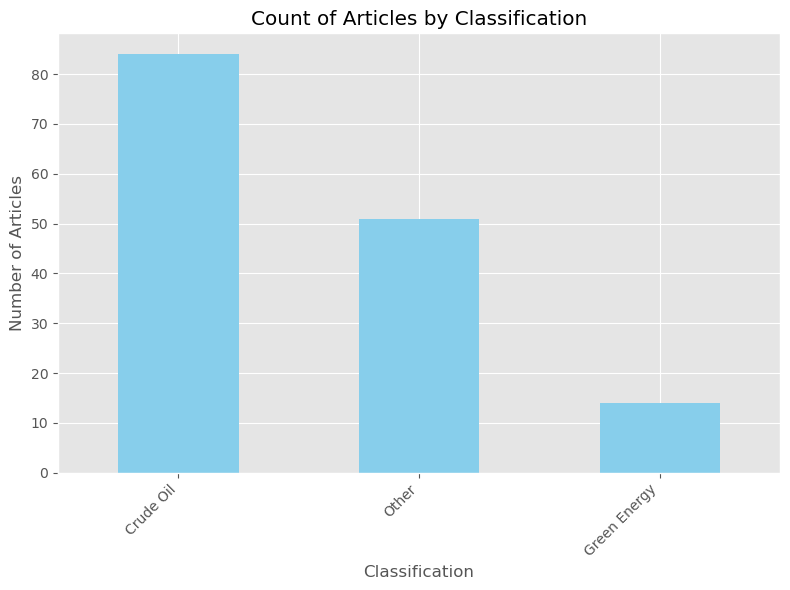

In [14]:
import matplotlib.pyplot as plt

# Count the occurrences of each classification
classification_counts = NYT_articles['classification'].value_counts()

# Plot the counts as a histogram
plt.figure(figsize=(8, 6))
classification_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Articles by Classification')
plt.xlabel('Classification')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Print OTHER classified rows to see if the filtering done properly

In [15]:
# Ensure all rows are printed without truncation
pd.set_option('display.max_rows', None)

# Filter the DataFrame for rows classified as 'Other'
other_classifications = NYT_articles[NYT_articles['classification'] == 'Other']

# Print only the 'headline', 'abstract', and 'classification' columns
other_classifications[['headline', 'abstract', 'classification']]


,headline,abstract,classification
3,Shipping Costs Soar in Wake of Red Sea Attacks,"Ships risking Houthi attacks must pay high insurance premiums, while vessels avoiding the region lose time going around Africa.",Other
5,Barricaded Highways and a Deadly Incident as French Farmers Rise Up,The far right is intent on exploiting the spread of anger across Europe in an agricultural sector that feels alienated.,Other
11,How Trump Sidestepped the Tradition of Iowa Pandering,"Presidential candidates often enmesh themselves in the state’s politics to woo voters, but the nature of this race means much less focus on local issues.",Other
15,Trump Dreams of Economic Disaster,"Why, exactly, do so many Americans admire this guy?",Other
16,Hertz Will Shrink Electric Fleet After Being Burned by Tesla’s Price Cuts,"The rental car company blamed the sharp drop in the value of electric vehicles and higher repair costs for its decision to sell 20,000 cars.",Other
22,World Bank Warns of Energy Price Surge if Mideast War Spreads,A new economic report predicted a year of weak growth and said the world faced a decade of “wasted opportunity.”,Other
23,"After the Capitol Attack, Companies Pledged to Rethink Political Giving. Did They?",A new analysis of corporate PAC donations shines light on an opaque political giving landscape.,Other
26,Biden’s Energy Balancing Act,The last few years have been great for energy production. You won’t hear the president bragging about it.,Other
29,What Are Your Favorite Local Businesses?,"Bookstores, pizza joints, Chinese restaurants, vintage shops, toy stores or anything else. What local spots do you want to celebrate?",Other
32,U.S. Campaign to Isolate Russia Shows Limits After 2 Years of War,"Many nations insist on not taking sides in the war in Ukraine, while China, India and Brazil are filling Russia’s coffers.",Other


# Let's Analyze the Green Energy rows

In [16]:
# Ensure all rows are printed without truncation
pd.set_option('display.max_rows', None)

# Filter the DataFrame for rows classified as 'Other'
other_classifications = NYT_articles[NYT_articles['classification'] == 'Green Energy']

# Print only the 'headline', 'abstract', and 'classification' columns
other_classifications[['headline', 'abstract', 'classification','compound_sentiment_score']]


,headline,abstract,classification,compound_sentiment_score
2,Democrats Say Biden Hasn’t ‘Made the Case’ on Climate Despite Achievements,The president likes to talk about his climate agenda as an opportunity to create jobs. Polling shows that may be the wrong way to win over voters.,Green Energy,0.475839
12,How This Climate Activist Justifies Political Violence,"“The reason that people contemplate escalation is that there are no risk-free options left,” says the author of ""How to Blow Up a Pipeline.""",Green Energy,0.876464
20,Missing Profits May Be a Problem for the Green Transition,The inability to generate acceptable returns is impeding the switch to renewable energy.,Green Energy,0.631066
37,"Ross Gelbspan, Who Exposed Roots of Climate Change Deniers, Dies at 84","A longtime investigative journalist, he wrote books and articles that documented a campaign of disinformation intended to sow doubt about global warming.",Green Energy,0.6503
47,U.N. Climate Chief Warns Countries Against ‘Hiding Behind Loopholes’,Simon Stiell used a speech in Azerbaijan to set expectations for global climate negotiations there this year.,Green Energy,0.290027
70,John Kerry: ‘I Feel Deeply Frustrated’,The departing climate envoy on what the world has and hasn’t achieved.,Green Energy,0.71415
78,"I’m a Young Conservative, and I Want My Party to Lead the Fight Against Climate Change","Instead of continuing the environmental legacy they were once known for, Republicans have ceded the fight against climate change to Democrats.",Green Energy,-0.407689
81,How Abrupt U-Turns Are Defining U.S. Environmental Regulations,"The polarization of politics means that rules are imposed, gutted and restored with each election. Experts say that’s bad for the economy.",Green Energy,0.842765
107,How China Rose to Lead the World in Cars and Solar Panels,"Heavy subsidies for industry, together with weak sales in China, have set the stage for an export boom, raising fears of factory job losses elsewhere.",Green Energy,-0.595961
118,"10 Big Biden Environmental Rules, and What They Mean","Asbestos, “forever” chemicals, E.V.s and endangered species. Here’s what 10 new rules cover, and why the administration has been churning them out.",Green Energy,0.0575


In [17]:
NYT_articles = results_df

# Save the merged DataFrame to a new CSV file

output_path = 'Final Cleaned Data with (Sentiment & Classification)/NYT_articles_results.csv'
NYT_articles.to_csv(output_path, index=False)

print(f"The merged DataFrame has been saved to {output_path}")

The merged DataFrame has been saved to Final Cleaned Data with (Sentiment & Classification)/NYT_articles_results.csv


# Now we are doing the same for the NYT

In [18]:
file_path = 'Final Cleaned Data/Final_X_articles.csv'

# Read the CSV files
X_tweets = pd.read_csv(file_path)
X_tweets.tail()



,tweet_count,tweet.created_at,tweet.user.name,tweet.user.location,tweet.user.followers_count,tweet.text,tweet.view_count,tweet.favorite_count,tweet.retweet_count,tweet.reply_count,tweet.media
1726,1727,2024-07-09 18:17:04+00:00,Asia Fact Check Lab,NaN,148,"A claim emerged among Chinese netizens in June that Saudi Arabia terminated a 50-year formal agreement with the U.S. to conduct oil transactions in dollars, under a deal called the “petrodollar agreement.”\n\nBut are the claims true: https://t.co/j6hooZcmV0 https://t.co/ZNDay8bMoj",66,3,1,0,"[{'display_url': 'pic.x.com/znday8bmoj', 'expanded_url': 'https://twitter.com/AFCL_eng/status/1810739964075999403/photo/1', 'id_str': '1810739960112369665', 'indices': [256, 279], 'media_key': '3_1810739960112369665', 'media_url_https': 'https://pbs.twimg.com/media/GSEKZmcaUAEbSeh.jpg', 'type': 'photo', 'url': 'https://t.co/ZNDay8bMoj', 'ext_media_availability': {'status': 'Available'}, 'features': {'large': {'faces': [{'x': 147, 'y': 299, 'h': 45, 'w': 45}]}, 'medium': {'faces': [{'x': 147, 'y': 299, 'h': 45, 'w': 45}]}, 'small': {'faces': [{'x': 92, 'y': 188, 'h': 28, 'w': 28}]}, 'orig': {'faces': [{'x': 147, 'y': 299, 'h': 45, 'w': 45}]}}, 'sizes': {'large': {'h': 1080, 'w': 1080, 'resize': 'fit'}, 'medium': {'h': 1080, 'w': 1080, 'resize': 'fit'}, 'small': {'h': 680, 'w': 680, 'resize': 'fit'}, 'thumb': {'h': 150, 'w': 150, 'resize': 'crop'}}, 'original_info': {'height': 1080, 'width': 1080, 'focus_rects': [{'x': 0, 'y': 0, 'w': 1080, 'h': 605}, {'x': 0, 'y': 0, 'w': 1080, 'h': 1080}, {'x': 0, 'y': 0, 'w': 947, 'h': 1080}, {'x': 0, 'y': 0, 'w': 540, 'h': 1080}, {'x': 0, 'y': 0, 'w': 1080, 'h': 1080}]}, 'media_results': {'result': {'media_key': '3_1810739960112369665'}}}]"
1727,1728,2024-07-09 18:28:45+00:00,House Appropriations,"Washington, DC",22922,The FY25 Interior and Environment Appropriations Act supports an all-of-the-above energy strategy: \n→ Promotes U.S. energy independence\n→ Requires onshore and offshore oil and gas lease sales\n→ Expands access to critical minerals\n→ Blocks onerous fees and regulations https://t.co/HwiDzCEW02,1787,9,2,4,"[{'display_url': 'pic.x.com/hwidzcew02', 'expanded_url': 'https://twitter.com/HouseAppropsGOP/status/1810742905470120438/video/1', 'id_str': '1810742434982416389', 'indices': [268, 291], 'media_key': '7_1810742434982416389', 'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/1810742434982416389/pu/img/k7-Ya33Ixf70WAdv.jpg', 'type': 'video', 'url': 'https://t.co/HwiDzCEW02', 'additional_media_info': {'monetizable': False}, 'ext_media_availability': {'status': 'Available'}, 'sizes': {'large': {'h': 1080, 'w': 1080, 'resize': 'fit'}, 'medium': {'h': 1080, 'w': 1080, 'resize': 'fit'}, 'small': {'h': 680, 'w': 680, 'resize': 'fit'}, 'thumb': {'h': 150, 'w': 150, 'resize': 'crop'}}, 'original_info': {'height': 1080, 'width': 1080, 'focus_rects': []}, 'video_info': {'aspect_ratio': [1, 1], 'duration_millis': 23600, 'variants': [{'content_type': 'application/x-mpegURL', 'url': 'https://video.twimg.com/ext_tw_video/1810742434982416389/pu/pl/3sWVtyEtEtVuQy7d.m3u8?tag=12'}, {'bitrate': 432000, 'content_type': 'video/mp4', 'url': 'https://video.twimg.com/ext_tw_video/1810742434982416389/pu/vid/avc1/320x320/JqmuJaxdPhTDC13S.mp4?tag=12'}, {'bitrate': 832000, 'content_type': 'video/mp4', 'url': 'https://video.twimg.com/ext_tw_video/1810742434982416389/pu/vid/avc1/540x540/2eVtvl67CDUjri7_.mp4?tag=12'}, {'bitrate': 1280000, 'content_type': 'video/mp4', 'url': 'https://video.twimg.com/ext_tw_video/1810742434982416389/pu/vid/avc1/720x720/vdO_-PF1Ba_ahkDk.mp4?tag=12'}]}, 'media_results': {'result': {'media_key': '7_1810742434982416389'}}}]"
1728,1729,2024-07-09 18:45:17+00:00,EIA,"Washington, DC",181421,☝️Correction: #Cryptocurrency mining. Apologies for the typo.,2245,1,0,0,NaN
1729,1730,2024-07-09 19:46:22+00:00,GetWireless,Minnesota,693,"💡100% of the top 20 U.S. oil and gas producers trust Semtech AirLink® router solutions to ensure remote dr

In [19]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm
import re

# Load model and tokenizer
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

# Function to calculate sentiment scores
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative_sentiment_score': scores[0],
        'neutral_sentiment_score': scores[1],
        'positive_sentiment_score': scores[2],
        'compound_sentiment_score': np.dot(scores, [-1, 0, 1])
    }
    return scores_dict

# Function to classify tweet as 'Crude Oil', 'Green Energy', or 'Other'
def classify_tweet(row):
    text = row['tweet.text']
    text = text.lower()  # Convert text to lowercase for consistent matching

    crude_oil_patterns = [
        r'\boil\b',  
        r'crude oil', 
        r'oil price(?:s)?',  
        r'oil market(?:s)?', 
        r'oil production', 
        r'oil demand(?:s)?', 
        r'oil supply', 
        r'oil reserves?',  
        r'oil futures?', 
        r'oil barrel(?:s)?', 
        r'oil drilling', 
        r'oil rigs?', 
        r'oil refinery', 
        r'oilfield', 
        r'oil well(?:s)?',  
        r'exxonmobil', 
        r'bp', 
        r'chevron', 
        r'shell', 
        r'totalenergies', 
        r'u\.s\. shale',  
        r'oil sanctions?', 
        r'oil embargo(?:es)?', 
        r'petroleum', 
        r'petroleum price(?:s)?',
        r'\bpetrol\b',
        r'\bgas\b',  
        r'\bgasoline\b',  
        r'gasoline price(?:s)?',
        r'fossil fuel(?:s)?', 
        r'hydrocarbon(?:s)?', 
        r'shale oil', 
        r'tar sands?', 
        r'brent crude', 
        r'west texas intermediate',
        r'\bWTI\b',  
        r'\bcoal\b',
        r'\bfuel\b',
        r'\bOPEC\b',
    ]

    green_energy_patterns = [
        r'green',
        r'green energy', 
        r'renewable(?:s)?',  
        r'solar', 
        r'wind', 
        r'clean energy', 
        r'green transition', 
        r'carbon neutral', 
        r'clean tech(?:nologies)?',  
        r'\bclimate change\b',       
        r'\bgreenhouse\b',           
        r'\bclimate\b',
        r'\benvironment\b',
        r'\benvironmental\b',            
    ]

    # Check if any crude oil related pattern matches the text
    if any(re.search(pattern, text) for pattern in crude_oil_patterns):
        return 'Crude Oil'
    
    # Check if any green energy related pattern matches the text
    elif any(re.search(pattern, text) for pattern in green_energy_patterns):
        return 'Green Energy'
    
    else:
        return 'Other'

# Adjust sentiment based on the topic of the tweet and invert the sentiment for Green Energy
def adjust_sentiment_based_on_topic(sentiment_dict, topic):
    # If the tweet is about Green Energy, invert the compound sentiment score
    if topic == 'Green Energy':
        sentiment_dict['compound_sentiment_score'] = -sentiment_dict['compound_sentiment_score']
        sentiment_dict['negative_sentiment_score'] = -sentiment_dict['negative_sentiment_score']
        sentiment_dict['positive_sentiment_score'] = -sentiment_dict['positive_sentiment_score']
        
        
    
    return sentiment_dict

# DataFrame to store results
res = {}

for i, row in tqdm(X_tweets.iterrows(), total=len(X_tweets)):
    try:
        text = row['tweet.text']
        myid = row['tweet_count']
        
        # Check for missing data
        if pd.isnull(row['tweet.text']):
            continue
        
        # Step 1: Get sentiment scores
        sentiment_scores = polarity_scores_roberta(text)
        
        # Step 2: Classify the tweet topic
        topic = classify_tweet(row)
        
        # Step 3: Adjust sentiment based on the topic
        sentiment_scores = adjust_sentiment_based_on_topic(sentiment_scores, topic)
        
        # Step 4: Store sentiment scores and classification
        sentiment_scores['classification'] = topic
        res[myid] = sentiment_scores

    except Exception as e:
        print(f'Error for tweet {myid}: {e}')

# Convert results into DataFrame
results_df = pd.DataFrame(res).T

# Add the classification column
results_df = results_df.reset_index().rename(columns={'index': 'tweet_count'})
results_df = results_df.merge(X_tweets, how='left')
X_tweets = results_df

# Display final DataFrame with classification
X_tweets.head()


100%|██████████| 1731/1731 [04:26<00:00,  6.49it/s]


,tweet_count,negative_sentiment_score,neutral_sentiment_score,positive_sentiment_score,compound_sentiment_score,classification,tweet.created_at,tweet.user.name,tweet.user.location,tweet.user.followers_count,tweet.text,tweet.view_count,tweet.favorite_count,tweet.retweet_count,tweet.reply_count,tweet.media
0,1,0.224576,0.714257,0.061168,-0.163408,Crude Oil,2024-01-02 13:10:06+00:00,EIA,"Washington, DC",181422,#TodayInEnergy - #Brent crude #oilprices averaged $19 per barrel less in 2023 than 2022 https://t.co/M9vt0n6fsn https://t.co/Gexe4zLnDm,20679,30,17,0,"[{'display_url': 'pic.x.com/gexe4zlndm', 'expanded_url': 'https://twitter.com/EIAgov/status/1742171408954736679/photo/1', 'id_str': '1742171381167509506', 'indices': [112, 135], 'media_key': '3_1742171381167509506', 'media_url_https': 'https://pbs.twimg.com/media/GC1vpAhXUAIfxgF.jpg', 'type': 'photo', 'url': 'https://t.co/Gexe4zLnDm', 'ext_media_availability': {'status': 'Available'}, 'features': {'large': {'faces': []}, 'medium': {'faces': []}, 'small': {'faces': []}, 'orig': {'faces': []}}, 'sizes': {'large': {'h': 518, 'w': 1007, 'resize': 'fit'}, 'medium': {'h': 518, 'w': 1007, 'resize': 'fit'}, 'small': {'h': 350, 'w': 680, 'resize': 'fit'}, 'thumb': {'h': 150, 'w': 150, 'resize': 'crop'}}, 'original_info': {'height': 518, 'width': 1007, 'focus_rects': [{'x': 82, 'y': 0, 'w': 925, 'h': 518}, {'x': 489, 'y': 0, 'w': 518, 'h': 518}, {'x': 553, 'y': 0, 'w': 454, 'h': 518}, {'x': 748, 'y': 0, 'w': 259, 'h': 518}, {'x': 0, 'y': 0, 'w': 1007, 'h': 518}]}, 'media_results': {'result': {'media_key': '3_1742171381167509506'}}}]"
1,2,0.004042,0.304035,0.691923,0.687881,Other,2024-01-02 18:11:37+00:00,EIA,"Washington, DC",181422,Reminder: #TodayInEnergy will see some big changes next week.\n\nToday In Energy will remain a critical source for energy analysis and will now be the home for several of our other analysis products. \n\nCheck out what's coming on our website 👇\nhttps://t.co/4ONwfWc9ee,6858,15,10,1,NaN
2,3,0.177734,0.775157,0.047109,-0.130625,Crude Oil,2024-01-02 19:04:55+00:00,EIA,"Washington, DC",181422,Annual average price of Brent crude #oil: \n\n🛢️ 2023: $83 per barrel \n🛢️ 2022: $101 per barrel\n\n➡️ https://t.co/wZ1Pgfn4tr https://t.co/IAqLWlrDsT,11759,27,9,1,"[{'display_url': 'pic.x.com/iaqlwlrdst', 'expanded_url': 'https://twitter.com/EIAgov/status/1742260703187144753/photo/1', 'id_str': '1742260672396660737', 'indices': [123, 146], 'media_key': '3_1742260672396660737', 'media_url_https': 'https://pbs.twimg.com/media/GC3A2cRWEAEoJ5s.png', 'type': 'photo', 'url': 'https://t.co/IAqLWlrDsT', 'ext_media_availability': {'status': 'Available'}, 'features': {'large': {'faces': []}, 'medium': {'faces': []}, 'small': {'faces': []}, 'orig': {'faces': []}}, 'sizes': {'large': {'h': 426, 'w': 805, 'resize': 'fit'}, 'medium': {'h': 426, 'w': 805, 'resize': 'fit'}, 'small': {'h': 360, 'w': 680, 'resize': 'fit'}, 'thumb': {'h': 150, 'w': 150, 'resize': 'crop'}}, 'original_info': {'height': 426, 'width': 805, 'focus_rects': [{'x': 44, 'y': 0, 'w': 761, 'h': 426}, {'x': 379, 'y': 0, 'w': 426, 'h': 426}, {'x': 431, 'y': 0, 'w': 374, 'h': 426}, {'x': 592, 'y': 0, 'w': 213, 'h': 426}, {'x': 0, 'y': 0, 'w': 805, 'h': 426}]}, 'media_results': {'result': {'media_key': '3_1742260672396660737'}}}]"
3,4,0.036057,0.877669,0.086275,0.050218,Other,2024-01-02 21:09:05+00:00,EIA,"Washington, DC",181422,We're adjusting our data release schedule due to the New Year's holiday on Monday. Check out our release schedule to see how things will change. \n\n👉 https://t.co/GUojmvnlgu https://t.co/nnvWtlnraJ,3671,7,1,1,"[{'display_url': 'pic.x.com/nnvwtlnraj', 'expanded_url': 'https://twitter.com/EIAgov/status/1742291950345027709/photo/1', 'id_str': '1742291929369362432', 'indices': [173, 196], 'media_key': '3_1742291929369362432', 'media_url_https': 'https://pbs.twimg.com/media/GC3dR1kXQAAqgqn.jpg', 'type': 'photo', 'url': 'https://t.co/nnvWtlnraJ', 'ext_media_availability': {'status': 'Available'}, 'featu

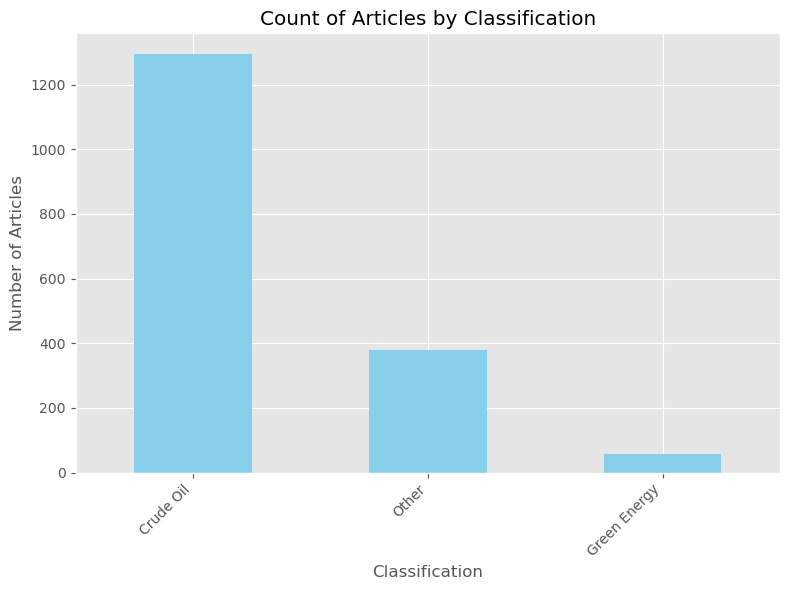

In [20]:
import matplotlib.pyplot as plt

# Count the occurrences of each classification
classification_counts = X_tweets['classification'].value_counts()

# Plot the counts as a histogram
plt.figure(figsize=(8, 6))
classification_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Articles by Classification')
plt.xlabel('Classification')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
